**Загружаем необходимые библиотеки**

In [73]:
import numpy as np
import pandas as pd
import random
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 10})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('max_colwidth', 200)

**Локальный путь до данных**

In [19]:
TRAIN_DATASET_PATH = '/Users/sonzza/Python_2_lessons/Finishhim/train.csv'
TEST_DATASET_PATH = '/Users/sonzza/Python_2_lessons/Finishhim/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Функция для оценки работы модели**

In [20]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

**Создание и беглый просмотр датасетов**

In [21]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.sample(7))
print(train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
333,11210,27,2.00000,68.45381,66.91893,0.00000,15,17.00000,1977,0.01765,B,B,2,469,0,nan,0,0,B,199508.37982
3314,561,56,3.00000,77.92224,49.14878,10.00000,10,17.00000,1985,0.00000,B,B,23,5067,4,nan,2,6,B,497376.46132
8654,3710,45,1.00000,42.31177,nan,1.00000,17,1.00000,1977,0.19578,B,B,23,5212,6,nan,3,2,B,217849.46783
8931,14132,27,1.00000,34.75825,17.13038,10.00000,17,25.00000,2013,0.07216,B,B,2,629,1,nan,0,0,A,105394.76173
4831,11749,23,1.00000,47.40656,nan,1.00000,4,4.00000,1977,0.01407,B,B,2,475,0,nan,0,0,B,111207.56542
392,15246,1,2.00000,64.06785,65.08119,1.00000,12,24.00000,1977,0.00712,B,B,1,264,0,nan,0,1,B,219119.83843
2166,7647,84,3.00000,73.34999,46.79992,9.00000,2,17.00000,2005,0.14967,B,B,22,4789,2,4087.00000,4,1,B,311640.06196


(10000, 20)


In [22]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,8383.40770,50.40080,1.89050,56.31578,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,4859.01902,43.58759,0.83951,21.05873,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,0.00000,0.00000,0.00000,1.13686,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,4169.50000,20.00000,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,8394.50000,36.00000,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,12592.50000,75.00000,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,16798.00000,209.00000,19.00000,641.06519,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [23]:
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.sample(7))
print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4904,8167,79,2.00000,46.76564,27.79916,5.00000,4,5.00000,1969,0.30747,B,A,30,5048,9,325.00000,2,5,B
711,7339,6,2.00000,67.88584,nan,1.00000,12,17.00000,1977,0.24320,B,B,5,1564,0,540.00000,0,0,B
3538,10552,10,2.00000,53.28379,32.47228,8.00000,18,17.00000,1989,0.08904,B,B,33,7976,5,nan,0,11,B
4379,10883,13,1.00000,42.59271,25.25848,8.00000,3,9.00000,2002,0.09080,B,B,74,19083,2,nan,5,15,B
2797,5302,29,1.00000,34.32561,21.18229,5.00000,4,5.00000,1963,0.06966,B,B,31,6119,4,nan,1,2,B
1503,13826,45,2.00000,64.75230,62.29379,1.00000,20,24.00000,2015,0.19578,B,B,23,5212,6,nan,3,2,B
1411,2981,27,2.00000,68.58180,66.86041,0.00000,13,0.00000,1977,0.07216,B,B,2,629,1,nan,0,0,A


(5000, 19)


In [24]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,8412.59540,51.27920,1.91000,56.44950,36.15881,5.97680,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,4832.67404,44.17947,0.83859,19.09279,17.82529,9.95002,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,1.00000,0.00000,0.00000,1.37854,0.33349,0.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,4221.75000,21.00000,1.00000,41.90623,23.09203,1.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,8320.50000,37.00000,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,12598.25000,77.00000,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,16795.00000,212.00000,17.00000,223.45369,303.07109,620.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


**Проверка на нулевые данные**

In [27]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [28]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

***посмотрим разброс по экологии, по жилой площади смотреть нет смысла там все достаточно уникально***

(array([ 4., 11., 15., 14.,  8.,  9.,  5.,  3.,  2.,  1.,  1.,  2.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([  1.  ,  13.75,  26.5 ,  39.25,  52.  ,  64.75,  77.5 ,  90.25,
        103.  , 115.75, 128.5 , 141.25, 154.  , 166.75, 179.5 , 192.25,
        205.  , 217.75, 230.5 , 243.25, 256.  , 268.75, 281.5 , 294.25,
        307.  , 319.75, 332.5 , 345.25, 358.  , 370.75, 383.5 , 396.25,
        409.  , 421.75, 434.5 , 447.25, 460.  , 472.75, 485.5 , 498.25,
        511.  ]),
 <a list of 40 Patch objects>)

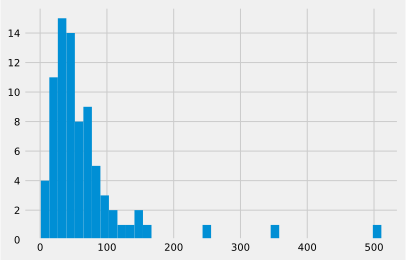

In [29]:
plt.hist(train_df['Healthcare_1'].value_counts(), bins=40)

**Принято решение заполнить пустые данные рандомным числом как признаком**

In [30]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = -13

In [31]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = -13

In [32]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = -13

In [33]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = -13

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


**Просмотр категориальных признаков и количества их уникальных значений**

In [36]:
train_df.describe(include=['O'])

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [37]:
test_df.describe(include=['O'])

,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000
unique,2,2,2
top,B,B,B
freq,4952,4851,4588


**Замена значений на бинарные и типа на int**

In [38]:
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1}).astype(int)

In [39]:
test_df['Ecology_2'] = test_df['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
test_df['Ecology_3'] = test_df['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
test_df['Shops_2'] = test_df['Shops_2'].replace({'A':0, 'B':1}).astype(int)

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(8), int64(12)
memory usage: 1.5 MB


**Просмотр выбросов и их замена**

In [41]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [42]:
test_df['Rooms'].value_counts()

2.00000     2030
1.00000     1769
3.00000     1099
4.00000       90
5.00000        7
0.00000        2
6.00000        2
17.00000       1
Name: Rooms, dtype: int64

In [43]:
train_df['Rooms'] = train_df['Rooms'].replace({10:1, 19:9})

In [44]:
test_df['Rooms'] = test_df['Rooms'].replace({17:7})

In [45]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [71]:
train_df['HouseYear'] = train_df['HouseYear'].replace({20052011:2011, 4968:1968})

In [75]:
now = datetime.datetime.now()
year=now.year
train_df.loc[:, 'HouseYear'] = year - train_df.loc[:, 'HouseYear']
test_df.loc[:, 'HouseYear'] = year - test_df.loc[:, 'HouseYear']
# получаем возраст дома вычитая текущий год из указанного

**Добавляем соотношение площадей в качестве признака**

In [76]:
train_df['ratio_by_square'] = train_df['Square']/train_df['LifeSquare']
test_df['ratio_by_square'] = test_df['Square']/test_df['LifeSquare']

In [77]:

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,ratio_by_square
0,14038,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,51,0.08904,1,1,33,7976,5,-13.00000,0,11,1,184966.93073,1.62966
1,15053,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,42,0.00007,1,1,46,10309,1,240.00000,1,16,1,300009.45006,1.64006
2,4765,53,2.00000,44.94795,29.19761,0.00000,8,12.00000,52,0.04964,1,1,34,7759,0,229.00000,1,3,1,220925.90852,1.53944
3,5809,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,43,0.43789,1,1,23,5735,3,1084.00000,0,5,1,175616.22722,1.01179
4,10783,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,44,0.01234,1,1,35,5776,1,2078.00000,2,4,1,150226.53164,1.66760


**Переход к построению и обучению модели**

In [78]:
feat_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'ratio_by_square']

In [79]:
X = train_df[feat_names]
y = train_df['Price']

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, shuffle=True, random_state=42)

In [81]:
gbr_model = GradientBoostingRegressor(n_estimators=500, max_depth=6, random_state=42)
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**Смотрим результаты**

Train R2:	0.978
Valid R2:	0.726


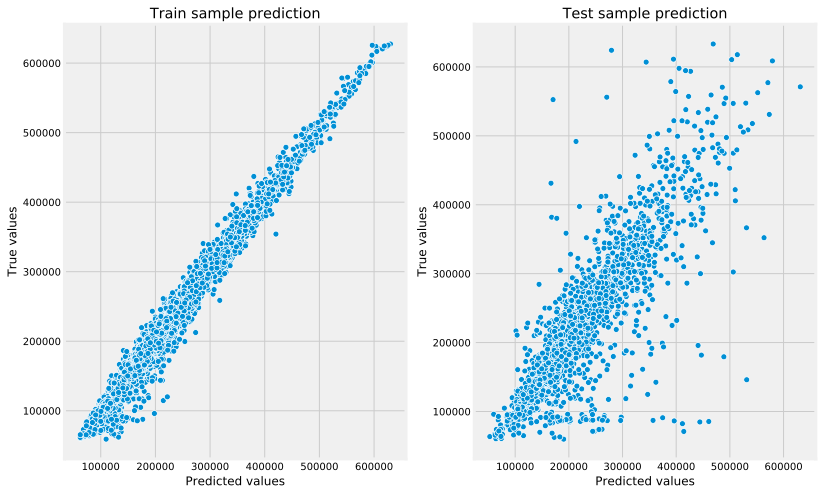

In [82]:
y_train_preds = gbr_model.predict(X_train)
y_val_preds = gbr_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_val_preds)

In [83]:
cv_score = cross_val_score(gbr_model, X, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=42))
cv_score

array([0.74454233, 0.73834696, 0.71670555, 0.72725979, 0.74035582,
       0.7780097 ])

In [84]:
cv_score.mean()

0.7408700254125619

In [93]:
feature_importances = pd.DataFrame(zip(X_train.columns, gbr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.39284
11,Social_2,0.10078
10,Social_1,0.08896
12,Social_3,0.07293
0,Rooms,0.06956
7,Ecology_1,0.05083
17,ratio_by_square,0.04054
6,HouseYear,0.03856
2,LifeSquare,0.02928
13,Healthcare_1,0.02400


**Предсказываем**

In [94]:
X2 = test_df[feat_names]

In [95]:
y_pred = gbr_model.predict(X2)

**Выгружаем во фрейм и в .csv**

In [96]:
result = pd.DataFrame(data = {'Id': test_df.Id, 'Price': y_pred})

In [97]:
result.head()

,Id,Price
0,725,151117.79867
1,15856,227017.43395
2,5480,201277.26137
3,15664,370982.10881
4,14275,134172.09113


In [98]:
result.to_csv('Kodrianu_Oksana_predictions_1.csv', index=False, quoting=3, sep=',')

In [99]:
results = pd.read_csv('Kodrianu_Oksana_predictions_1.csv')

In [100]:
results.shape

(5000, 2)